# Assignment II – Convolutional Neural Networks

Welcome to assignment 2! In this notebook we will help with some parts of the code and the rest is for you to fill in. If you find any errors, or have any feedback, please contact `joelwall@kth.se` or `mats.persson@mi.physics.kth.se`.

In this assignment, we will classify images into three classes. There are three image data sets to choose from, namely:
1. `histopathology`,
2. `galaxies`,
3. `brain-stroke`.

The goal is to train different classification models in order to achieve high accuracy on the test data set associated to your category of images. First we will perform classification on some hand-crafted features extracted from the image, then we will continue with convolutional neural networks that can automatically learn important features in the images in order to (hopefully!) yield higher classification accuracy.

In [1]:
import os
import numpy as np
from tqdm import tqdm
from PIL import Image

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from skimage.measure import shannon_entropy
from scipy.stats import skew

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Setup dataset class
When dealing with more complex datasets, it is recommended to use a custom PyTorch Dataset class to manage your data. This approach allows you to neatly organize how data are loaded, preprocessed, and accessed during training. A dataset class must implement two essential methods:

- `__len__()` — returns the total number of samples in the dataset, and

- `__getitem__(index)` — defines how a single data sample (and its label) is retrieved when the dataset is indexed or iterated over in a training loop.

In [2]:
class FullImageDataset(Dataset):
    """
    Loads all images from train/val/test directories into memory.
    Directory structure must be:
        root_dir/train/<class_name>/
        root_dir/val/<class_name>/
        root_dir/test/<class_name>/
    """

    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = os.path.join(root_dir, split)
        self.transform = transform

        # Class names (sorted for consistent label indices)
        self.class_names = sorted([
            d for d in os.listdir(self.root_dir)
            if os.path.isdir(os.path.join(self.root_dir, d))
        ])
        self.num_classes = len(self.class_names)

        self.images, self.labels = [], []
        print(f"Loading {split} data from {self.root_dir} ...")

        for label_idx, class_name in enumerate(self.class_names):
            class_dir = os.path.join(self.root_dir, class_name)
            for fname in tqdm(os.listdir(class_dir), desc=f"{class_name}"):
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):

                    path = os.path.join(class_dir, fname)
                    img = Image.open(path)

                    if 'brain-stroke' in root_dir:
                        img = img.convert('L')  # Grayscale for brain-stroke dataset
                    else:
                        img = img.convert('RGB')  # Ensure RGB for other datasets

                    self.images.append(img)
                    self.labels.append(label_idx)

        self.labels = np.array(self.labels)
        self.labels_onehot = np.eye(self.num_classes)[self.labels]
        print(self.labels_onehot.shape)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label_onehot = self.labels_onehot[idx]
        label = self.labels[idx]
        
        if self.transform:
            img = self.transform(img)

        # convert one-hot label to tensor
        label_onehot = torch.tensor(label_onehot, dtype=torch.float32)

        return img, label_onehot, label

# Load datasets

First we load the training data to compute mean and std needed for normalization of the full images. Then we load everything again with the correct transform. This is for later purposes when we will use the CNN.

In [3]:
data_root = r"C:\Users\T480s\OneDrive\Documents\aKTH\KTH Second Year\ML_physics\SH2150_assignments\assignment2\brain-stroke" # TODO: change to your chosen dataset

def compute_mean_std(pil_images):
    to_tensor = transforms.ToTensor()
    imgs_torch = torch.stack([to_tensor(img) for img in pil_images])
    mean = imgs_torch.mean(dim=[0, 2, 3])
    std  = imgs_torch.std(dim=[0, 2, 3])
    return mean, std

# Just load data without any transform to compute mean and std
train_data = FullImageDataset(data_root, 'train', transform=None)

mean, std = compute_mean_std(train_data.images)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist())
])

print(f"Training data mean: {mean}")
print(f"Training data std:  {std}")

Loading train data from C:\Users\T480s\OneDrive\Documents\aKTH\KTH Second Year\ML_physics\SH2150_assignments\assignment2\brain-stroke\train ...


Normal: 100%|██████████| 700/700 [00:00<00:00, 1743.51it/s]


(2100, 3)
Training data mean: tensor([0.1853])
Training data std:  tensor([0.3036])


...load all three parts of the dataset with the correct transform this time

In [4]:
train_data = FullImageDataset(data_root, 'train', transform=transform)
val_data   = FullImageDataset(data_root, 'val', transform=transform)
test_data  = FullImageDataset(data_root, 'test', transform=transform)

X_train, y_train = train_data.images, train_data.labels
X_val, y_val = val_data.images, val_data.labels
X_test, y_test = test_data.images, test_data.labels

print(f"Classes: {train_data.class_names}")
print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")


Loading train data from C:\Users\T480s\OneDrive\Documents\aKTH\KTH Second Year\ML_physics\SH2150_assignments\assignment2\brain-stroke\train ...


Normal: 100%|██████████| 700/700 [00:00<00:00, 1789.69it/s]


(2100, 3)
Loading val data from C:\Users\T480s\OneDrive\Documents\aKTH\KTH Second Year\ML_physics\SH2150_assignments\assignment2\brain-stroke\val ...


Normal: 100%|██████████| 150/150 [00:00<00:00, 1732.59it/s]


(450, 3)
Loading test data from C:\Users\T480s\OneDrive\Documents\aKTH\KTH Second Year\ML_physics\SH2150_assignments\assignment2\brain-stroke\test ...


Normal: 100%|██████████| 150/150 [00:00<00:00, 1576.35it/s]

(450, 3)
Classes: ['Bleeding', 'Ischemia', 'Normal']
Train: 2100, Val: 450, Test: 450


# Hand-crafted Features

In [5]:
def extract_features(X):
    """
    Compute simple features from each image.
    Returns an (N, D) array of features.
    """
    feats = []
    for img in tqdm(X):
        np_img = np.array(img)
        if np_img.ndim == 2:
            gray = np.array(img)
        elif np_img.ndim == 3:
            gray = np.mean(img, axis=-1)
        mean_intensity = np.mean(gray) #If you want, replace with a feature of your choice
        std_intensity = np.std(gray)  # TODO: implement standard deviation, or replace with another feature of your choice
        # TODO: add your own features until you have 3-5. For example, you can use the mean absolute gradient based on np.gradient()
        gy, gx = np.gradient(gray); grad_mag = np.sqrt(gx**2 + gy**2)
        mean_gradient = np.mean(grad_mag)
        entropy = shannon_entropy(gray)
        skewness = skew(gray.flatten())
        feats.append([mean_intensity, std_intensity, mean_gradient, entropy, skewness]) # add your features here
    return np.array(feats)

print("Extracting features...")
X_train_feats = extract_features(X_train)
X_val_feats = extract_features(X_val)
X_test_feats = extract_features(X_test)

# Normalize features (important!)
scaler = StandardScaler()
X_train_feats = scaler.fit_transform(X_train_feats)
X_val_feats = scaler.transform(X_val_feats)
X_test_feats = scaler.transform(X_test_feats)


Extracting features...


100%|██████████| 450/450 [00:00<00:00, 531.22it/s]


# 1. Unsupervised K-means Clustering

In [6]:
#TODO: create a kmeans object and use it to perform k-means clustering
#of the training set into three clusters
kmeans = KMeans(n_clusters=3).fit(X=X_train_feats)

print (X_train_feats.shape)

print(len(kmeans.labels_))

(2100, 5)
2100


In [7]:
from scipy.stats import mode

# Map each cluster to the most common true label in that cluster
cluster_labels = np.zeros(3, dtype=int)
for i in range(3):
    mask = (kmeans.labels_ == i)
    # y_train[mask] keeps only the y_train data that corresponds to cluster i
    # then find the mode of that data, so the most commonly occuring class for cluster i
    # for example, cluster_labels[0] = 2 means the most commonly occuring class for cluster 0 is class 2!
    cluster_labels[i] = mode(y_train[mask], keepdims=False).mode # mode returns the value that appears most often
    
# Predict on test set. test_clusters is now an array with each value containing the cluster index it belongs to
test_clusters = kmeans.predict(X=X_test_feats) # TODO: predict cluster indices for test set
# print (test_clusters)
# print (cluster_labels)
# print (cluster_labels[test_clusters])
y_pred_kmeans = cluster_labels[test_clusters] # now it's an array of actual cluster number! (not cluster index)

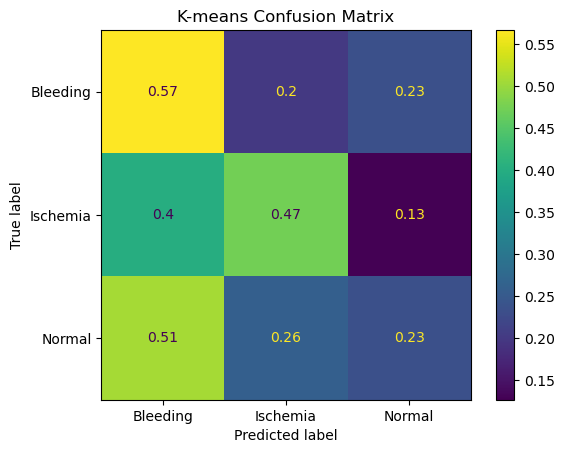

Accuracy: 0.42444444444444446


In [8]:
cm = confusion_matrix(y_test, y_pred_kmeans, normalize='true')
ConfusionMatrixDisplay(cm, display_labels=train_data.class_names).plot()
plt.title("K-means Confusion Matrix")
plt.savefig(r"C:\Users\T480s\OneDrive\Documents\aKTH\KTH Second Year\ML_physics\SH2150_assignments\assignment2\figures\1c_CM.png", dpi=300)
plt.show()

acc = accuracy_score(y_true=y_test, y_pred=y_pred_kmeans)
print ("Accuracy:", acc)

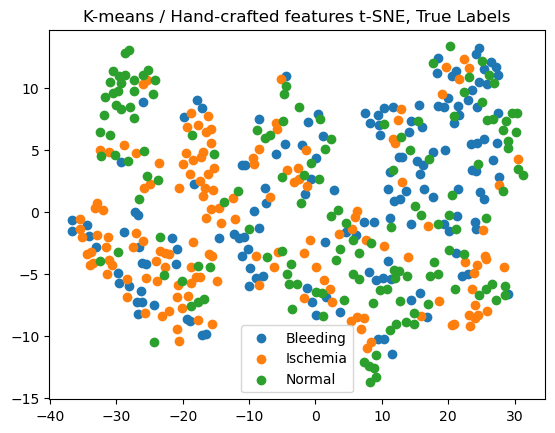

In [9]:
# TODO create a TSNE object tsne and use fit_transform() to create a 2D
# embedding X_test_2d
X_test_2d = TSNE().fit_transform(X=X_test_feats)

plt.figure()
for i, name in enumerate(train_data.class_names):
    plt.scatter(X_test_2d[y_test == i, 0], X_test_2d[y_test == i, 1], label=name)
plt.legend(); plt.title("K-means / Hand-crafted features t-SNE, True Labels"); 
plt.savefig(r"C:\Users\T480s\OneDrive\Documents\aKTH\KTH Second Year\ML_physics\SH2150_assignments\assignment2\figures\1c_TrueLabels.png")
plt.show()

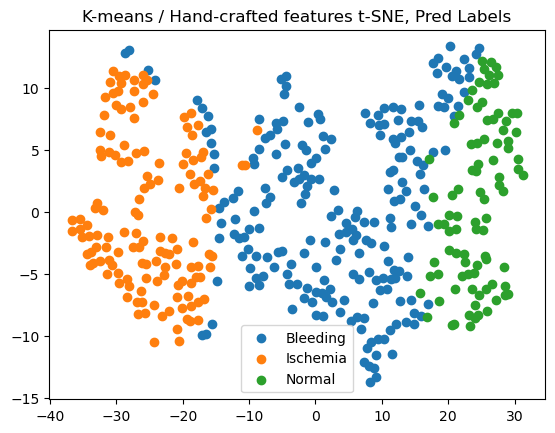

In [10]:
# TODO create a TSNE object tsne and use fit_transform() to create a 2D
# embedding X_test_2d
# X_test_2d = TSNE().fit_transform(X=X_test_feats)

plt.figure()
for i, name in enumerate(train_data.class_names):
    plt.scatter(X_test_2d[y_pred_kmeans == i, 0], X_test_2d[y_pred_kmeans == i, 1], label=name)
plt.legend(); plt.title("K-means / Hand-crafted features t-SNE, Pred Labels"); 
plt.savefig(r"C:\Users\T480s\OneDrive\Documents\aKTH\KTH Second Year\ML_physics\SH2150_assignments\assignment2\figures\1c_PredLabels.png")
plt.show()

# 2. MLP classifier

At this point you are ready to code the model in large part by yourself!
Use the below code skeleton which outlines what you need to do. You are welcome to reuse code from the first lab if you want.

In [11]:
class MLP(nn.Module):
    def __init__(self, in_features: int, hidden_features: list, out_features: int):
        super(MLP, self).__init__()

        layers = []
        
        # Input → first hidden layer
        layers.append(nn.Linear(in_features, hidden_features[0])) # TODO: implement linear layer
        layers.append(nn.ReLU()) # TODO add ReLU activation

        # Hidden → hidden
        for i in range(len(hidden_features) - 1):
            # TODO add more linear + ReLU layers according to hidden_features
            layers.append(nn.Linear(hidden_features[i], hidden_features[i + 1]))
            layers.append(nn.ReLU())
        
        # Last hidden → output layer with Softmax activation
        # TODO: implement this
        layers.append(nn.Linear(hidden_features[-1], out_features))
        layers.append(nn.Softmax(dim=1))

        # Build the full network
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [12]:
# Convert to torch tensors
X_train_t = torch.tensor(X_train_feats).float()
y_train_t = torch.tensor(y_train).long()
X_val_t   = torch.tensor(X_val_feats).float()
y_val_t   = torch.tensor(y_val).long()

## Train

In [13]:
print (X_train_feats.shape)
y_train_oneHot = nn.functional.one_hot(y_train_t, num_classes=3).float()

(2100, 5)


In [ ]:
def cross_entropy_loss(y_pred, y_true):

    # Ensure y_pred is clamped to avoid log(0)
    y_pred = torch.clamp(y_pred, 1e-7, 1 - 1e-7)
    
    # Compute binary cross-entropy loss
    # loss = - (y_true * torch.log(y_pred) + (1 - y_true) * torch.log(1 - y_pred)) # TODO: implement cross-entropy loss, you can use torch.log
    loss = -torch.sum(y_true * torch.log(y_pred), dim=1)
    
    # Return mean loss over all samples
    return loss.mean()

In [15]:
mlp = MLP(in_features=X_train_feats.shape[1], hidden_features=[512, 32], out_features=3)
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3) #TODO: define this
# criterion = nn.CrossEntropyLoss() #TODO: define this
criterion = cross_entropy_loss

# Training loop
train_losses, val_losses = [], []
num_epochs = 500
for epoch in range(num_epochs):
    mlp.train()
    optimizer.zero_grad() # TODO: Zero gradients,
    out = mlp(X_train_t) # TODO: forward pass: apply model to X_train_t
    loss = criterion(out, y_train_oneHot) # TODO calculate loss
    # TODO perform a backward pass and update the weights.
    loss.backward()
    optimizer.step()

    mlp.eval()
    with torch.no_grad():
        val_out = mlp(X_train_t)
        val_loss = criterion(val_out, y_train_oneHot) #TODO: calculate validation loss

    # TODO: store training and validation losses in train_losses and val_losses
    train_losses.append(loss.item()); val_losses.append(val_loss.item())


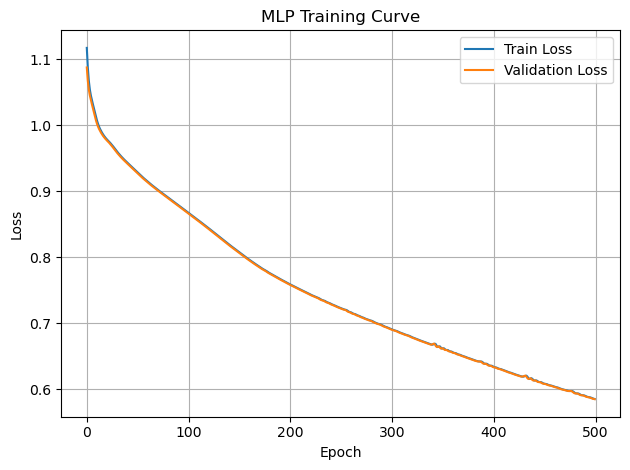

In [16]:
# TODO: make a plot with two curves: training and validation loss. Don't forget
# the legends. Suggested title "MLP Training Curve"
plt.plot(np.arange(0, num_epochs), train_losses, label='Train Loss')
plt.plot(np.arange(0, num_epochs), val_losses, label='Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title("MLP Training Curve")
plt.grid(); plt.legend(); plt.tight_layout()
plt.savefig(r"C:\Users\T480s\OneDrive\Documents\aKTH\KTH Second Year\ML_physics\SH2150_assignments\assignment2\figures\2b_losses.png", dpi=300)
plt.show()

## Evaluate

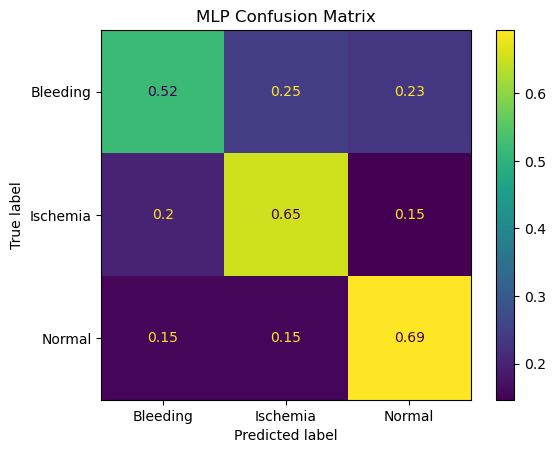

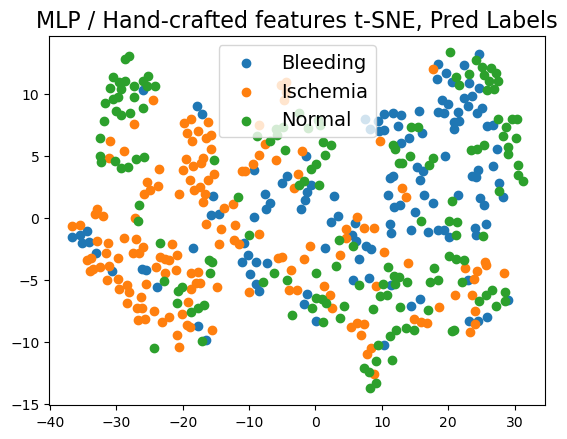

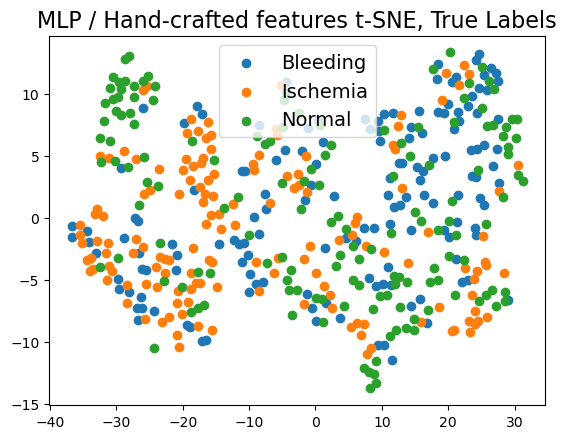

Accuracy: 0.6222222222222222


In [17]:
# Evaluate on test
mlp.eval()
with torch.no_grad():
    y_pred = mlp(torch.tensor(X_test_feats).float()).argmax(1).numpy()
    
# TODO: Plot a confusion matrix similar to above for the MLP classification
# Suggested title "MLP Confusion Matrix"
cm = confusion_matrix(y_test, y_pred, normalize='true')
ConfusionMatrixDisplay(cm, display_labels=train_data.class_names).plot()
plt.title("MLP Confusion Matrix")
plt.savefig(r"C:\Users\T480s\OneDrive\Documents\aKTH\KTH Second Year\ML_physics\SH2150_assignments\assignment2\figures\2c_CM.png", dpi=300)
plt.show()

# TODO create a TSNE object tsne and use fit_transform() to create a 2D
# embedding X_test_2d

X_test_2d = TSNE().fit_transform(X=X_test_feats)

plt.figure()
for i, name in enumerate(train_data.class_names):
    plt.scatter(X_test_2d[y_pred == i, 0], X_test_2d[y_pred == i, 1], label=name)
plt.legend(fontsize=14); plt.title("MLP / Hand-crafted features t-SNE, Pred Labels", fontsize=16); 
plt.savefig(r"C:\Users\T480s\OneDrive\Documents\aKTH\KTH Second Year\ML_physics\SH2150_assignments\assignment2\figures\2c_PredLabels.png")
plt.show()

# TODO create a TSNE object tsne and use fit_transform() to create a 2D
# embedding X_test_2d
# X_test_2d = TSNE().fit_transform(X=X_test_feats)

plt.figure()
for i, name in enumerate(train_data.class_names):
    plt.scatter(X_test_2d[y_test == i, 0], X_test_2d[y_test == i, 1], label=name)
plt.legend(fontsize=14); plt.title("MLP / Hand-crafted features t-SNE, True Labels", fontsize=16); 
plt.savefig(r"C:\Users\T480s\OneDrive\Documents\aKTH\KTH Second Year\ML_physics\SH2150_assignments\assignment2\figures\2c_TrueLabels.png")
plt.show()

acc = accuracy_score(y_true=y_test, y_pred=y_pred)
print ("Accuracy:", acc)


# 3. CNN

In [18]:
class CNN(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=4, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(kernel_size=2),
            #TODO: add three more layers according to the CNN architecture in
            # Fig. 1, with 3x3 filters. The last layer should have 32 output channels.
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(kernel_size=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # TODO: add linear + ReLU + Linear + Softmax according to Fig. 1
            nn.Linear(in_features=2048, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=3),
            nn.Softmax(dim=1), 
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [19]:
in_channels = 1 # TODO define how many input channels your images have (are they grayscale or RGB?)

cnn = CNN(in_channels = in_channels)
optimizer = torch.optim.Adam(cnn.parameters(), lr=1e-3) #TODO define this
criterion = cross_entropy_loss #TODO define this

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

train_loss_curve, val_loss_curve = [], []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn.to(device) # this moves the model to GPU if available

CNN(
  (features): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=3, bias=True)
    (4): Softmax(dim=1)
  )
)

## Train

In [20]:
train_loss_curve, val_loss_curve = [], []
num_epochs_cnn = 6
for epoch in range(num_epochs_cnn):
    cnn.train()
    total_loss = 0
    for imgs, labels, _ in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        # TODO: Zero gradients, compute forward pass, calculate loss, perform a backward pass,
        # and update the weights. Calculate training loss and add to total_loss
        optimizer.zero_grad()
        out = cnn(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_loss_curve.append(total_loss / len(train_loader))

    cnn.eval()
    val_loss = 0
    with torch.no_grad():
        for imgs, labels, _ in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            # TODO calculate validation loss and add to val_loss.
            val_out = cnn(imgs)
            val_loss += criterion(val_out, labels).item()
            
    # TODO: save total validation loss, normalized by the number of training samples,
    # in val_loss_curve
    val_loss_curve.append(val_loss / len(val_loader))

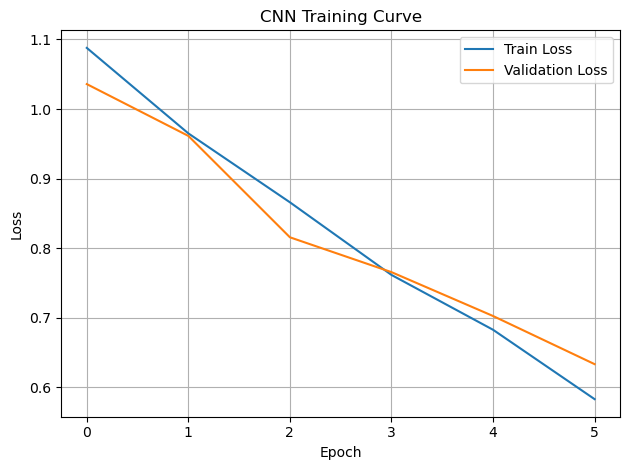

In [21]:
# TODO: make a plot with two curves: training and validation loss, similar to
# before. Suggested title "CNN Training Curve"
plt.plot(np.arange(0, num_epochs_cnn), train_loss_curve, label='Train Loss')
plt.plot(np.arange(0, num_epochs_cnn), val_loss_curve, label='Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title("CNN Training Curve")
plt.grid(); plt.legend(); plt.tight_layout()
plt.savefig(r"C:\Users\T480s\OneDrive\Documents\aKTH\KTH Second Year\ML_physics\SH2150_assignments\assignment2\figures\3b_losses.png", dpi=300)
plt.show()

## Evaluate

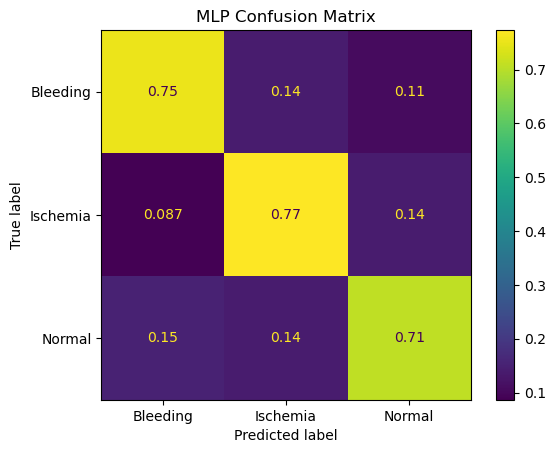

Accuracy: 0.7444444444444445


In [22]:
test_loader = DataLoader(test_data, batch_size=32)

# Evaluate CNN
cnn.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for imgs, _, labels in test_loader:
        imgs = imgs.to(device)
        outputs = cnn(imgs)
        y_true.extend(labels.numpy())
        y_pred.extend(outputs.argmax(1).cpu().numpy())

# TODO: Plot a confusion matrix similar to above for the MLP classification
# Suggested title "CNN Confusion Matrix"
cm = confusion_matrix(y_true, y_pred, normalize='true')
ConfusionMatrixDisplay(cm, display_labels=train_data.class_names).plot()
plt.title("MLP Confusion Matrix")
plt.savefig(r"C:\Users\T480s\OneDrive\Documents\aKTH\KTH Second Year\ML_physics\SH2150_assignments\assignment2\figures\3c_CM.png", dpi=300)
plt.show()

acc = accuracy_score(y_true=y_true, y_pred=y_pred)
print ("Accuracy:", acc)

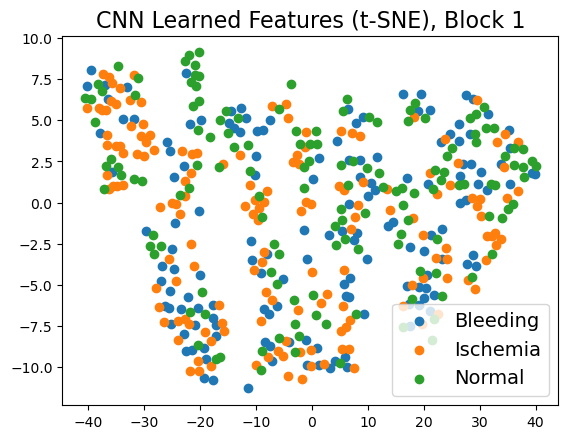

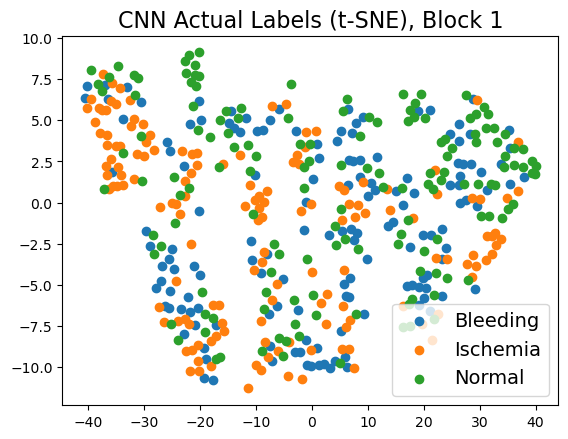

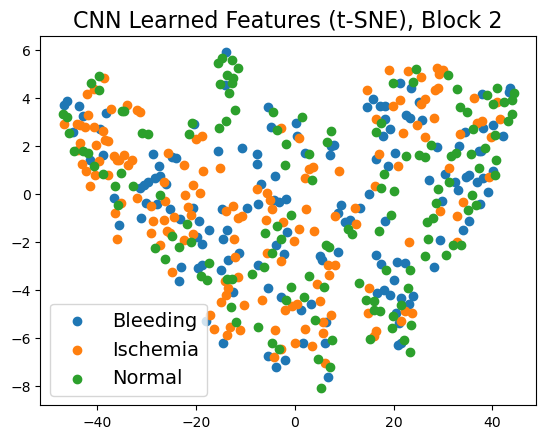

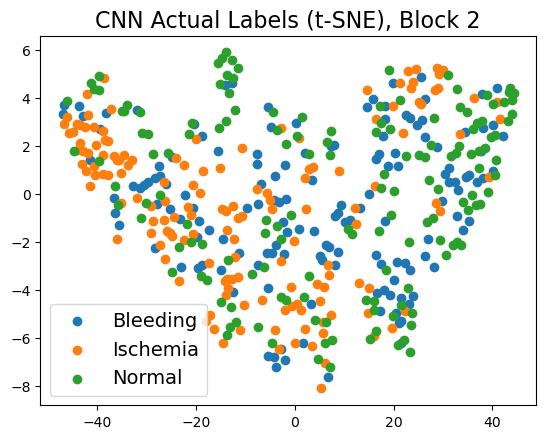

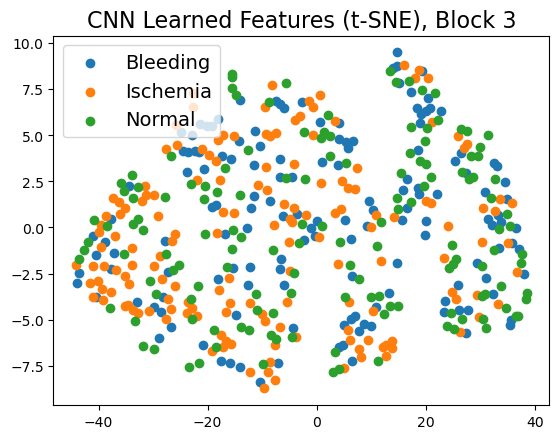

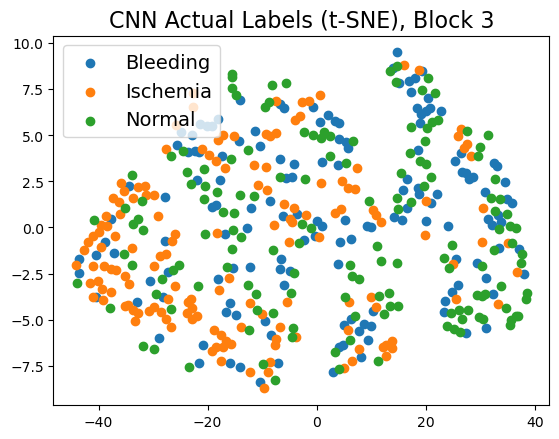

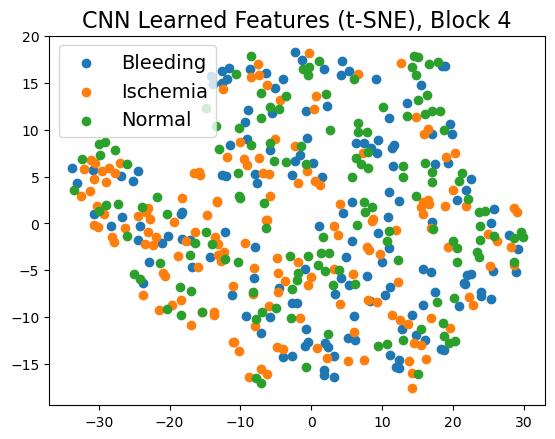

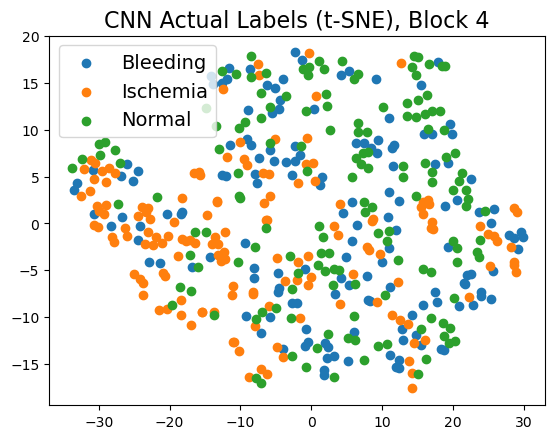

In [23]:


def extract_features(model, loader, block=1):
    feats, labels_all = [], []
    n_layers = (block * 3) - 1 # here 3 is the number of layers per block, starts at layer 0
    model.eval()
    with torch.no_grad():
        for imgs, _, labels in loader:
            f = imgs.to(device)
            for layer in range(n_layers):
                f = model.features[layer](f) #TODO extract features from each label
            feats.append(f.mean(dim=(2,3)).cpu().numpy())
            labels_all.append(labels.numpy())
    return np.concatenate(feats), np.concatenate(labels_all)

for block_nr in range(1, 5):
    cnn_feats, cnn_labels = extract_features(model=cnn, loader=val_loader, block=block_nr) #TODO Calculate features and labels for all layers.
    cnn_feats_2d = TSNE().fit_transform(X=cnn_feats) #TODO Compute 2D embedding of cnn_feats using t-SNE

    # TODO Make a plot of the t-SNE embedding of the learned features.
    # "CNN Learned Features (t-SNE)"
    y_pred = np.array(y_pred)

    plt.figure()
    for i, name in enumerate(train_data.class_names):
        plt.scatter(cnn_feats_2d[y_pred == i, 0], cnn_feats_2d[y_pred == i, 1], label=name)
    plt.legend(fontsize=14); plt.title(f"CNN Learned Features (t-SNE), Block {block_nr}", fontsize=16); 
    plt.savefig(rf"C:\Users\T480s\OneDrive\Documents\aKTH\KTH Second Year\ML_physics\SH2150_assignments\assignment2\figures\3d_t_SNE_pred_B{block_nr}.png")
    plt.show()
    
    plt.figure()
    for i, name in enumerate(train_data.class_names):
        plt.scatter(cnn_feats_2d[cnn_labels == i, 0], cnn_feats_2d[cnn_labels == i, 1], label=name)
    plt.legend(fontsize=14); plt.title(f"CNN Actual Labels (t-SNE), Block {block_nr}", fontsize=16); 
    plt.savefig(rf"C:\Users\T480s\OneDrive\Documents\aKTH\KTH Second Year\ML_physics\SH2150_assignments\assignment2\figures\3d_t_SNE_actual_B{block_nr}.png")
    plt.show()
    
    # acc = accuracy_score(y_true=cnn_labels, y_pred=y_pred)
    # print (f"Accuracy, block {block_nr}:", acc)